### Importing Necessary Libraries

In [18]:
import numpy as np
import torch
import faiss

from tern.datasets import CocoDataset
from tern.tools.configs import Config
from tern.modules.models.encoder.modal import TERN
from tern.tools.inference import make_query_embeddings, make_gallery_embeddings, faiss_search, show_retrieval

## Data

Let's visualize a images from the `Flickr30k` dataset.

In [14]:
dataset = CocoDataset(
    root_dir="/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images", 
    ann_path="/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json", 
    image_size=224, 
    keep_ratio=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


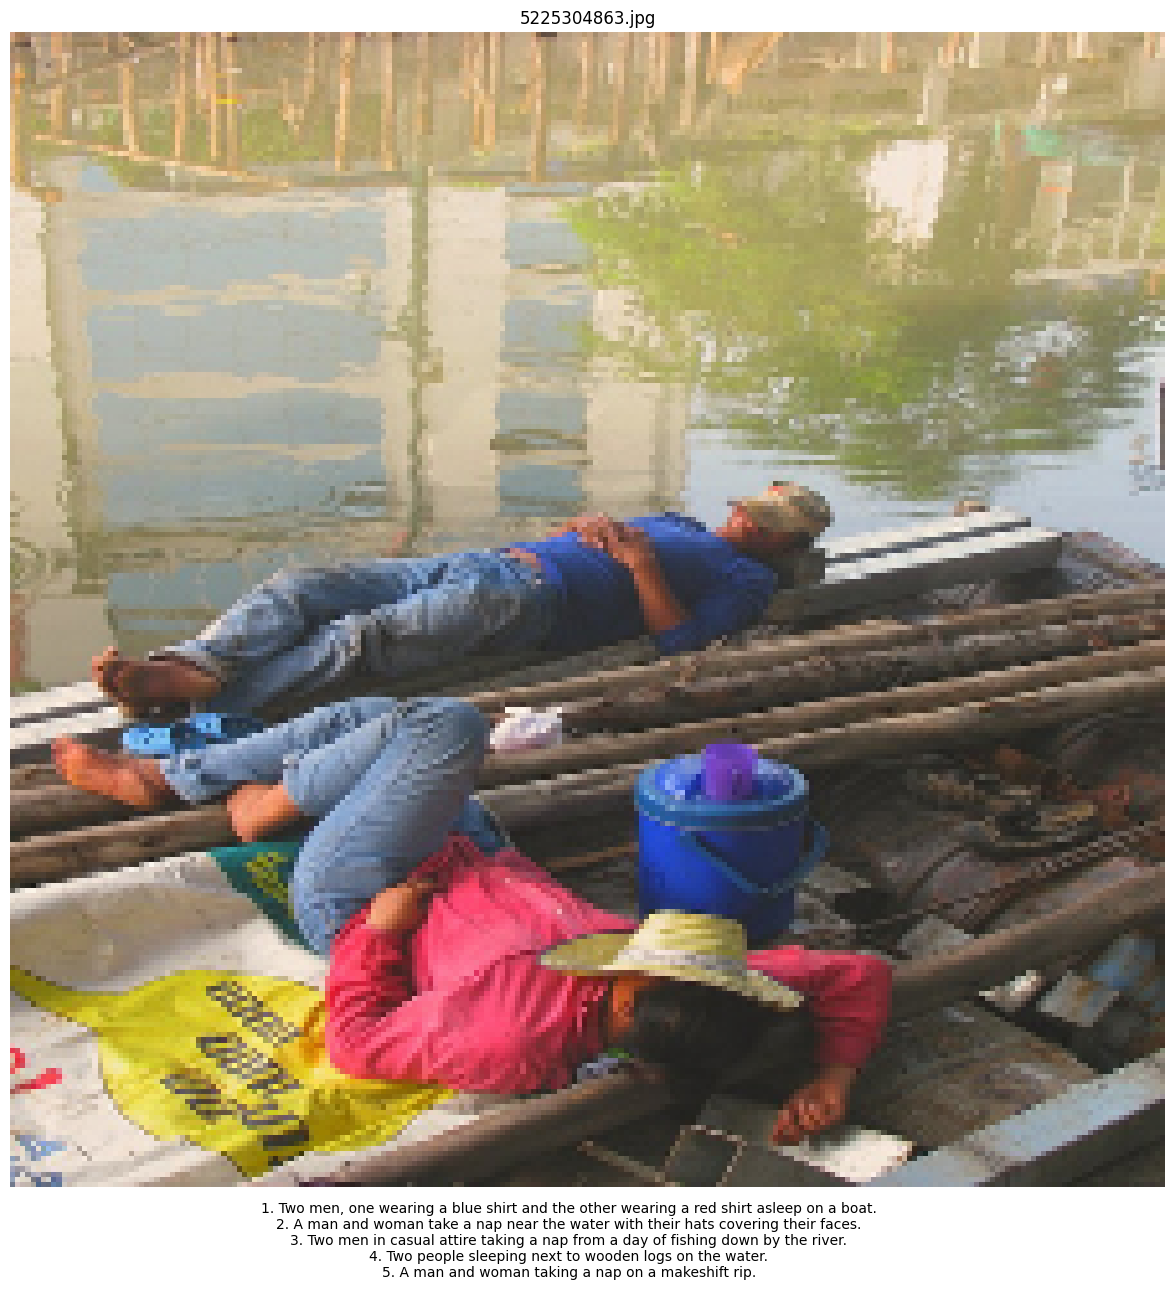

In [15]:
dataset.visualize_item()

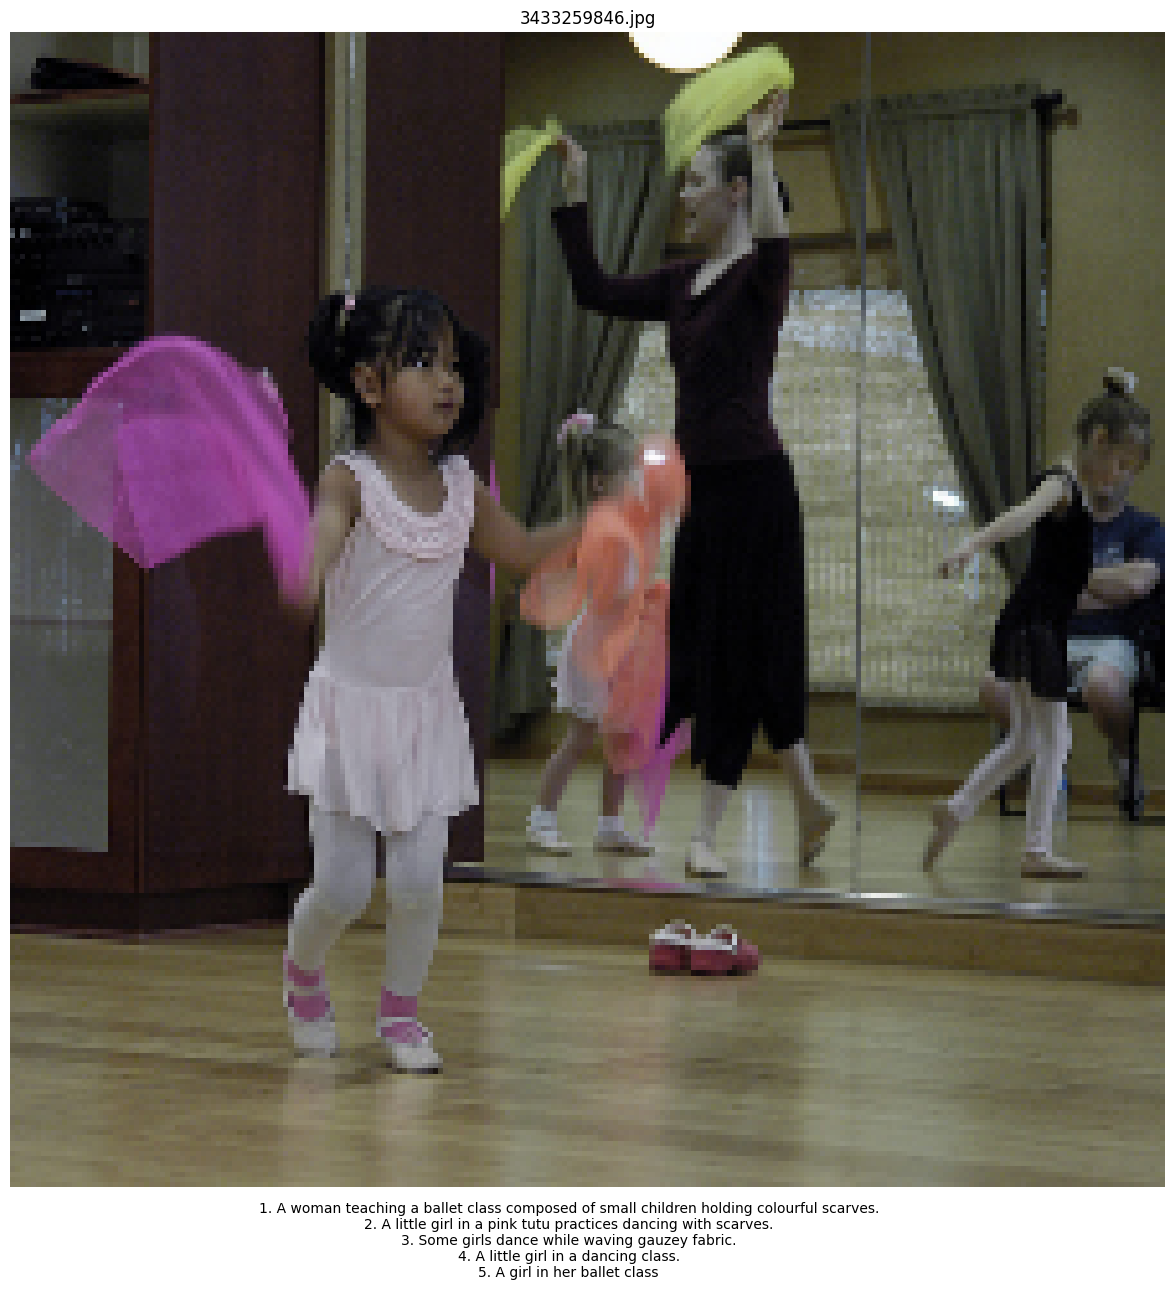

In [16]:
dataset.visualize_item()

## Model

In [21]:
device = torch.device('cpu')
config = Config('/Users/rishideychowdhury/Desktop/Joint-Embedding/TERN-RPE/tern/tools/configs/yaml/tern.yaml')
config.model['args'].update({'precomp_bert': False})
model = TERN(**config.model['args'])
model.load_state_dict(torch.load('/Users/rishideychowdhury/Desktop/Joint-Embedding/Models/TERN_best.pth', map_location=device)['model'])
model = model.to(device)
model.eval()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TERN(
  (encoder_v): EncoderBottomUp(
    (feat_embed): FeatureEmbedding(
      (linear): Linear(in_features=2048, out_features=768, bias=True)
    )
    (loc_embed): SpatialEncoding(
      (linear): Linear(in_features=5, out_features=768, bias=True)
    )
  )
  (encoder_l): EncoderBERT()
  (reasoning_v): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (norm_1): LayerNorm()
        (norm_2): LayerNorm()
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=768, out_features=768, bias=True)
          (v_linear): Linear(in_features=768, out_features=768, bias=True)
          (k_linear): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (out): Linear(in_features=768, out_features=768, bias=True)
        )
        (ff): PositionwiseFeedForward(
          (w_1): Linear(in_features=768, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=768, 

In [22]:
faiss_pool = faiss.IndexFlatIP(config.model['args']['d_embed'])

In [23]:
img_infos, gallery_embeddings = make_gallery_embeddings(
    ann_path = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_annotations/val.json", 
    feat_dir = "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/bottom_up",
    model = model, device = device)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1014it [00:05, 171.29it/s]


## Inference

In [66]:
query_text = "Football."
query_embeddings = make_query_embeddings(query_text, model, device)

In [67]:
top_k_indexes, top_k_scores = faiss_search(faiss_pool, query_embeddings, gallery_embeddings, top_k=10)

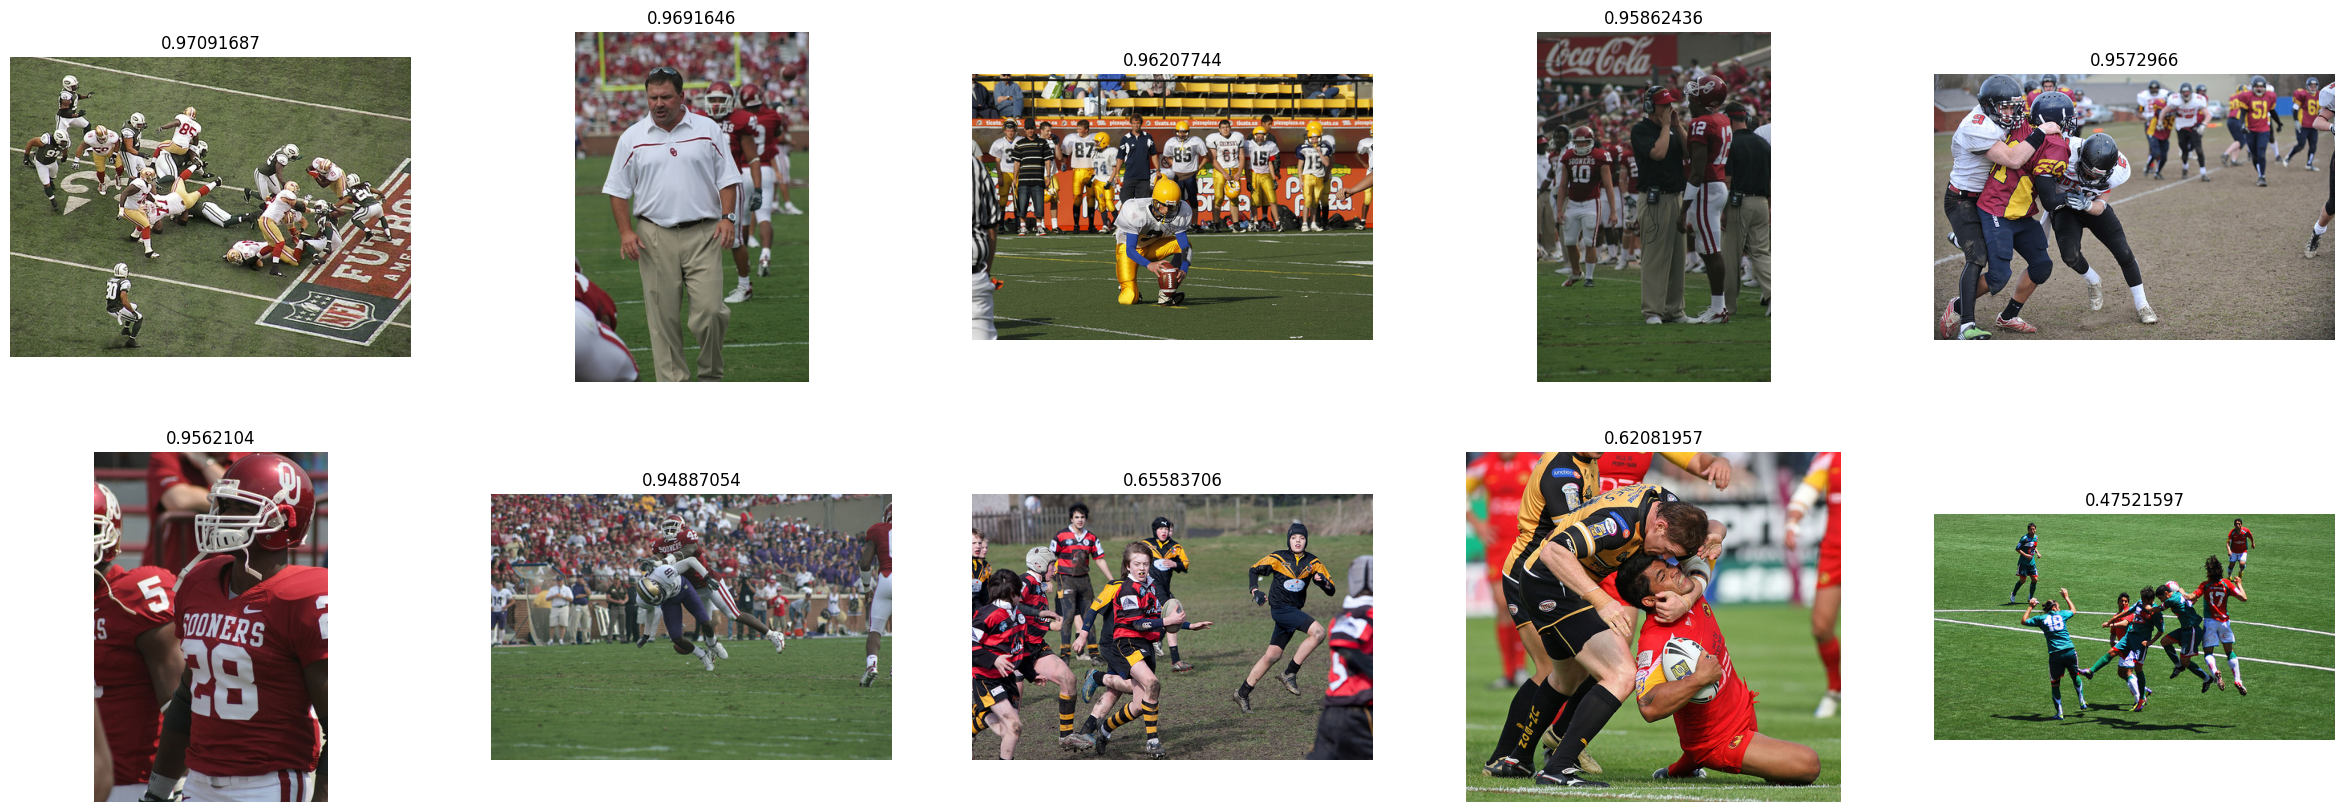

In [68]:
show_retrieval(
    "/Users/rishideychowdhury/Desktop/Joint-Embedding/Data/flickr30k_images/flickr30k_images/flickr30k_images", 
    img_infos, top_k_indexes, top_k_scores)